Import Libraries

In [1]:
# Import libraries
import os
import pydicom as dicom
import pandas as pd
from tabulate import tabulate
import matplotlib as plt
from matplotlib import figure, pyplot
from statistics import median, mean
import numpy as np
import SimpleITK as sitk
import csv
import seaborn as sns
import scipy

Define paths

In [2]:
# Define path to data (images and probability maps)
dataPath = "/Users/ilanadeutsch/Desktop/TextureAnalysisFinal"
dataDir = os.listdir(dataPath)

# Define path to data curation (excel sheet)
curation = pd.read_excel(r"/Users/ilanadeutsch/Desktop/BAP1 data curation.xlsx", sheet_name = "Disease laterality - Feng")

Initialize Variables

In [3]:
# Define variables
m_yes = 0
m_no = 0
f_yes = 0
f_no = 0

y_age = []
n_age = []

y_pixel = []
n_pixel = []

y_slice = []
n_slice = []
y_scanner = []
n_scanner = []

y_kvp = []
n_kvp = []

size = []
names = []

y_size = []
n_size = []

tot_y_size = []
tot_n_size = []

y_size_print = []
n_size_print = []

Gather info on age, sex, slice thickness, scanner manufacturer, pixel spacing, and KVP

In [4]:
# Gather data on patient age, patient sex, slice thickness, scanner manufacturer, pixel spacing, and KVP.
for caseNum, case in enumerate(dataDir):

    # Skip invisible entry
    if case == ".DS_Store":
        continue

    # Define image path
    imgsPath = os.path.join(dataPath, dataDir[caseNum], "OriginalImgs")
    imgsDir = os.listdir(imgsPath)
    
    # Read in dicom info
    ds = dicom.read_file(os.path.join(imgsPath, imgsDir[0]))

    # Link to patient to BAP1 status
    for ipatient,patient in enumerate(curation["Case"]):
        if patient in case:
            status = curation.iloc[ipatient,7]

    # Determine sex
    if ds.PatientSex == "M":
       if status == "Yes":
         m_yes = m_yes + 1
       else:
           m_no = m_no +1
    if ds.PatientSex == "F":
        if status == "Yes":
            f_yes = f_yes + 1
        else:
           f_no = f_no +1

    # Determine age
    if status == "Yes":
        y_age.append((int(ds.PatientAge[1:3])))
    else:
        n_age.append((int(ds.PatientAge[1:3])))

    # Scanner data
    if status == "Yes":
        y_slice.append(int(ds.SliceThickness))
        y_scanner.append(ds.Manufacturer)
        y_pixel.append(float(ds.PixelSpacing[0]))
        y_kvp.append(float(ds.KVP))
    else:
        n_slice.append(int(ds.SliceThickness))
        n_scanner.append(ds.Manufacturer)
        n_pixel.append(float(ds.PixelSpacing[0]))
        n_kvp.append(float(ds.KVP))

Summarize data collected

In [5]:
# Calculate medians and ranges and sums for data collected
y_median = median(y_age)
n_median = median(n_age)

y_range = f"{min(y_age)}-{max(y_age)}"
n_range = f"{min(n_age)}-{max(n_age)}"

t_age = y_age + n_age
t_median = int(median(t_age))
t_range = f"{min(t_age)}-{max(t_age)}"

y_slice_median = median(y_slice)
y_slice_range = f"{min(y_slice)}-{max(y_slice)}"
n_slice_median = median(n_slice)
n_slice_range = f"{min(n_slice)}-{max(n_slice)}"

t_slice = y_slice + n_slice
t_slice_median = median(t_slice)
t_slice_range = f"{min(t_slice)}-{max(t_slice)}"

# Sums
n_GE = len([scanner for scanner in n_scanner if scanner == "GE MEDICAL SYSTEMS"])
y_GE = len([scanner for scanner in y_scanner if scanner == "GE MEDICAL SYSTEMS"])

n_philips = len([scanner for scanner in n_scanner if scanner == "Philips"])
y_philips = len([scanner for scanner in y_scanner if scanner == "Philips"])

n_toshiba = len([scanner for scanner in n_scanner if scanner == "TOSHIBA"])
y_toshiba = len([scanner for scanner in y_scanner if scanner == "TOSHIBA"])

n_siemens = len([scanner for scanner in n_scanner if scanner == "SIEMENS"])
y_siemens = len([scanner for scanner in y_scanner if scanner == "SIEMENS"])

y_pixel_median = "{:.2}".format(median(y_pixel))
y_pixel_range = f"{round(min(y_pixel),2)}-{round(max(y_pixel),2)}"

n_pixel_median = "{:.2f}".format(median(n_pixel))
n_pixel_range = f"{round(min(n_pixel),2)}-{round(max(n_pixel),2)}"

t_pixel_median = "{:.2f}".format(median(n_pixel + y_pixel))
t_pixel_range = f"{round(min(n_pixel + y_pixel),2)}-{round(max(n_pixel + y_pixel),2)}"

n_kvp_median = "{:.2f}".format(median(n_kvp))
n_kvp_range = f"{round(min(n_kvp),2)}-{round(max(n_kvp),2)}"

y_kvp_median = "{:.2f}".format(median(y_kvp))
y_kvp_range = f"{round(min(y_kvp),2)}-{round(max(y_kvp),2)}"

t_kvp_median = "{:.2f}".format(median(n_kvp+y_kvp))
t_kvp_range = f"{round(min(n_kvp),2)}-{round(max(n_kvp+y_kvp),2)}"

t_cases = f_yes + f_no + m_yes + m_no
t_yes = f_yes + m_yes
t_no = f_no + m_no

Display tables of demographic and CT data

In [7]:
# Display Demographic Data
headers = ["Characteristic",f"Total (n = {t_cases})", f"BAP1 Mutation Status [+] (n = {t_yes}) ",f"BAP1 Mutation Status [-] (n = {t_no})"]
data = [["Sex","","",""],["Male", m_yes + m_no ,m_yes,m_no],["Female",f_yes + f_no ,f_yes,f_no],["Age","","",""],["Median",int(t_median),y_median,n_median],["Range",t_range,y_range,n_range]]
print(tabulate(data, headers=headers))

print("\n")

# Display CT data
headers = ["Characteristic",f"Total (n = {t_cases})", f"BAP1 Mutation Status [+] (n = {t_yes})",f"BAP1 Mutation Status [-] (n = {t_no})"]
data = [["Pixel Size [mm]","","",""],["Median",t_pixel_median,y_pixel_median,n_pixel_median], ["Range",t_pixel_range,y_pixel_range,n_pixel_range],
        ["Slice Thickness [mm]","","",""],["Median",t_slice_median,y_slice_median,n_slice_median],["Range","1-5",y_slice_range,n_slice_range],["kVp [kV]","","",""],
        ["Median",t_kvp_median,y_kvp_median,n_kvp_median],["Range",t_kvp_range,y_kvp_range,n_kvp_range],["Scanner Manufacturer","","",""],
        ["GE",y_GE + n_GE,y_GE,n_GE],["Philips",y_philips + n_philips,y_philips,n_philips],
        ["Toshiba", y_toshiba+n_toshiba,y_toshiba,n_toshiba],["Siemens",y_siemens + n_siemens,y_siemens,n_siemens],]
print(tabulate(data, headers=headers))

Characteristic    Total (n = 131)    BAP1 Mutation Status [+] (n = 60)     BAP1 Mutation Status [-] (n = 71)
----------------  -----------------  ------------------------------------  -----------------------------------
Sex
Male              84                 42                                    42
Female            47                 18                                    29
Age
Median            69                 69.0                                  69
Range             21-90              51-90                                 21-81


Characteristic        Total (n = 131)    BAP1 Mutation Status [+] (n = 60)    BAP1 Mutation Status [-] (n = 71)
--------------------  -----------------  -----------------------------------  -----------------------------------
Pixel Size [mm]
Median                0.72               0.71                                 0.73
Range                 0.56-1.07          0.57-1.07                            0.56-0.95
Slice Thickness [mm]
Median               

Threshold map function

In [8]:
# Define threshold map function
def thresholdedMap(map,threshold):
    size = map.GetSize()
    im = np.zeros(size)
    for i in range(size[0]):
        for j in range(size[1]):
            if map[i,j]>= threshold:
                im[i,j] = 1
            else:
                im[i,j] = 0
    return im

Gather info on tumor size/volume (~5 minutes)

In [9]:
# Gather info on tumor size and volume (NOTE: Cells takes about 5 minutes to run)
for caseNum, case in enumerate(dataDir):

    # Reset total area for new case
    tot_size_temp = 0

    # Skip invisible entries
    if case == ".DS_Store":
        continue

    # Save a list of the case names
    names.append(case)

    # Define image path
    imgsPath = os.path.join(dataPath, dataDir[caseNum], "OriginalImgs")
    imgsDir = os.listdir(imgsPath)
        
    # Read in dicom info
    ds = dicom.read_file(os.path.join(imgsPath, imgsDir[0]))

    # Define map
    mapsPath = os.path.join(dataPath, dataDir[caseNum], "Masks_Resampled")
    mapsDir = os.listdir(mapsPath)

    # Loop through slices
    for sliceNum, slice in enumerate(mapsDir):


        # Define probability map
        mapPath = os.path.join(mapsPath, mapsDir[int(sliceNum)])
        map = sitk.ReadImage(mapPath)

        # Threshold map
        map = thresholdedMap(map,0.01)

        # Link to patient to BAP1 status
        for ipatient,patient in enumerate(curation["Case"]):
            if patient in case:
                status = curation.iloc[ipatient,7]
                
        # Save tumor size according to BAP1 status
        if status == "Yes":
            if sliceNum == 1:
                y_size.append(sum(map[map==1])*(ds.PixelSpacing[0]*ds.PixelSpacing[1]))
        else:
            if sliceNum == 1:
                n_size.append(sum(map[map==1])*(ds.PixelSpacing[0]*ds.PixelSpacing[1]))

        tot_size_temp = + tot_size_temp + sum(map[map==1])*ds.PixelSpacing[0]*ds.PixelSpacing[1]

    # Save cumulative tumor size
    if status == "Yes":
        tot_y_size.append(tot_size_temp)
    else:
        tot_n_size.append(tot_size_temp)

# Multiple by 3 to find volume
tot_y_size = [size*3 for size in tot_y_size]
tot_n_size = [size*3 for size in tot_n_size]

# Print median tumor volume
print(f"Median BAP1 [-] vol: {median(tot_n_size)}")
print(f"Median BAP1 [+] vol: {median(tot_y_size)}\n")

# Print minumum tumor volume
print(f"Min BAP1 [-] vol: {min(tot_n_size)}")
print(f"Min BAP1 [+] vol: {min(tot_y_size)}\n")

# Print maximum tumor volume
print(f"Max BAP1 [-] vol: {max(tot_n_size)}")
print(f"Max BAP1 [+] vol: {max(tot_y_size)}\n")

# Run statistical test for difference between volume distributions
scipy.stats.ranksums(n_size,y_size)

Median BAP1 [-] vol: 14485.320693969727
Median BAP1 [+] vol: 11045.156442590689

Min BAP1 [-] vol: 2134.259033203125
Min BAP1 [+] vol: 1323.046875

Max BAP1 [-] vol: 66560.74507141113
Max BAP1 [+] vol: 98412.84245578159



RanksumsResult(statistic=2.0695545199933547, pvalue=0.038494080789893526)

Create tumor area histogram

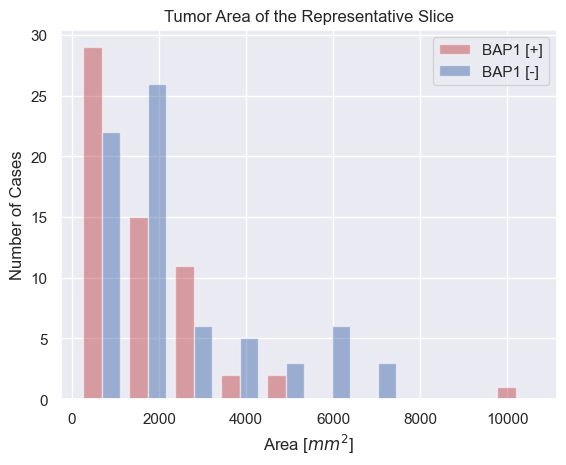

In [11]:
# Plot histogram of tumor area for middle slice
sns.set_theme()
plt.pyplot.xlabel("Area [$mm^2$]")
plt.pyplot.title("Tumor Area of the Representative Slice")
plt.pyplot.ylabel("Number of Cases")
plt.pyplot.hist([y_size, n_size],color=['r','b'], alpha=0.5, label=['BAP1 [+]','BAP1 [-]'] )
plt.pyplot.legend()

Create tumor volume histogram

In [ ]:
# Plot tumor volume
sns.set_theme()
plt.pyplot.hist([tot_y_size, tot_n_size],color=['r','b'], alpha=0.5, label=['BAP1 [+]','BAP1 [-]'] )
plt.pyplot.legend()
plt.pyplot.title("Tumor Volume")
plt.pyplot.xlabel("Volume [$mm^3$]")
plt.pyplot.ylabel("Number of Cases")

Create tumor volume histogram

Text(0, 0.5, 'Number of Cases')

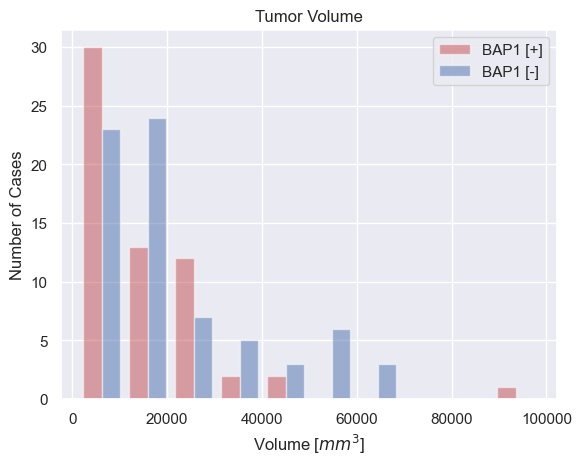

In [30]:
# Plot tumor volume
sns.set_theme()
plt.pyplot.hist([tot_y_size, tot_n_size],color=['r','b'], alpha=0.5, label=['BAP1 [+]','BAP1 [-]'] )
plt.pyplot.legend()
plt.pyplot.title("Tumor Volume")
plt.pyplot.xlabel("Volume [$mm^3$]")
plt.pyplot.ylabel("Number of Cases")

Create age histogram

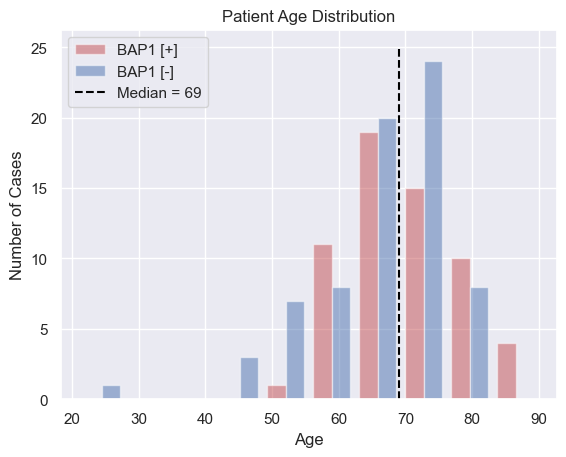

In [12]:
# Plot age histogram
sns.set_theme()
plt.pyplot.xlabel("Age")
plt.pyplot.ylabel("Number of Cases")
plt.pyplot.title("Patient Age Distribution")
plt.pyplot.hist([y_age,n_age], color=['r','b'], alpha=0.5,label=['BAP1 [+]','BAP1 [-]'])
plt.pyplot.vlines(x = t_median , ymin = 0, ymax = 25,
          linestyles = "dashed", colors = "black", label = f"Median = {t_median}")  
plt.pyplot.legend()

Gather info on reconstruction kernels

In [ ]:
# Initialize necessary lists
kernel = []
y_GE = []
y_p = []
y_t = []
y_s = []
n_GE = []
n_p = []
n_t = []
n_s = []

# Gather info on reconstruction kernels (NOTE: there are ~20 different kernels,
# data must be interpreted manually)
for caseNum, case in enumerate(dataDir):

    # Skip invisible entry
    if case == ".DS_Store":
        continue

    # Define image path
    imgsPath = os.path.join(dataPath, dataDir[caseNum], "OriginalImgs")
    imgsDir = os.listdir(imgsPath)
    
    # Read in dicom info
    ds = dicom.read_file(os.path.join(imgsPath, imgsDir[0]))

    # Link to patient to BAP1 status
    for ipatient,patient in enumerate(curation["Case"]):
        if patient in case:
            status = curation.iloc[ipatient,7]

    # Scanner data
    if status == "Yes":
        if ds.Manufacturer == "GE MEDICAL SYSTEMS":
            y_GE.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "Philips":
            y_p.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "TOSHIBA":
            y_t.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "SIEMENS":
            y_s.append(ds.ConvolutionKernel)
    else:
        if ds.Manufacturer == "GE MEDICAL SYSTEMS":
            n_GE.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "Philips":
            n_p.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "TOSHIBA":
            n_t.append(ds.ConvolutionKernel)
        if ds.Manufacturer == "SIEMENS":
            n_s.append(ds.ConvolutionKernel) 


Determine tumor size in relation to classifier prediction

In [3]:
# Define path to predictions (file with case names in one column, classifier
# prediction in second column (0 or 1) and true BAP1 status in third column (0 or 1)
predictions = pd.read_csv(r'/Users/ilanadeutsch/Desktop/predictions.csv')

# Path to csv with case names in column 1 and tumor size in column 2
sizes =  pd.read_csv(r'/Users/ilanadeutsch/Desktop/tumorsizes.csv')

# Intialize lists
y_size = []
n_size = []

# Loop through each case, determining size and classification results
for val1, case1 in enumerate(predictions["Case"]):
    for val2, case2 in enumerate(sizes["Case"]):
        if case1 in case2:
            if predictions.iloc[val1,2] == predictions.iloc[val1,3]:
                y_size.append(sizes.iloc[val2,1])
            else:
                n_size.append(sizes.iloc[val2,1])

# Print mean size of correctly and incorrectly classified tumors
print(f"Mean correctly classified tumor size: {mean(y_size)}")
print(f"Mean incorrectly classified tumor size: {mean(n_size)}")

FileNotFoundError: [Errno 2] No such file or directory: '/Users/ilanadeutsch/Desktop/predictions.csv'

Gather info on reconstruction kernels